In [1]:
!nvidia-smi

Thu Jan 16 16:39:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1D:00.0 Off |                  N/A |
| 27%   31C    P8    13W / 250W |     10MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1E:00.0 Off |                  N/A |
| 27%   31C    P0    75W / 250W |     10MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')

from ce_utils import load_data, one_hot, test_batch_idxs, batch_flatten
from ce_utils import model_prob
from ce_utils import classification_metric
from ce_model import binary_model, ensemble_model

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

In [3]:
neg_img, neg_name = load_data('test', 'n', 'neg', data = 'sm_x160', extract_name = True)
redspot_img, redspot_name = load_data('test', 'h', 'redspot', data = 'sm_x160', extract_name = True)
angio_img, angio_name = load_data('test', 'h', 'angio', data = 'sm_x160', extract_name = True)
active_img, active_name = load_data('test', 'h', 'active', data = 'sm_x160', extract_name = True)
ero_img, ero_name = load_data('test', 'd', 'ero', data = 'sm_x160', extract_name = True)
ulcer_img, ulcer_name = load_data('test', 'd', 'ulcer', data = 'sm_x160', extract_name = True)
str_img, str_name = load_data('test', 'd', 'str', data = 'sm_x160', extract_name = True)

In [4]:
neg_label = one_hot(neg_img, 0)
redspot_label = one_hot(redspot_img, 1)
angio_label = one_hot(angio_img, 1)
active_label = one_hot(active_img, 1)
ero_label = one_hot(ero_img, 1)
ulcer_label = one_hot(ulcer_img, 1)
str_label = one_hot(str_img, 1)

print("negative:",neg_img.shape, neg_label.shape)
print("red spot:",redspot_img.shape, redspot_label.shape)
print("angioectasia:",angio_img.shape, angio_label.shape)
print("active_bleeding:",active_img.shape, active_label.shape)
print("erosion:",ero_img.shape, ero_label.shape)
print("ulcer:",ulcer_img.shape, ulcer_label.shape)
print("stricture:",str_img.shape, str_label.shape)

negative: (11592, 512, 512, 3) (11592, 2)
red spot: (18240, 512, 512, 3) (18240, 2)
angioectasia: (480, 512, 512, 3) (480, 2)
active_bleeding: (19520, 512, 512, 3) (19520, 2)
erosion: (19360, 512, 512, 3) (19360, 2)
ulcer: (22560, 512, 512, 3) (22560, 2)
stricture: (4960, 512, 512, 3) (4960, 2)


# Model Inference

In [11]:
nh_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'X160_NX40H' in i])
nd_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'X160_NX40D' in i])
b_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'X160_NX40A' in i])

In [12]:
nh_list

['X160_NX40H_2001161345_10_val_acc_0.60_val_loss_0.680715',
 'X160_NX40H_2001161345_40_val_acc_0.86_val_loss_0.384926',
 'X160_NX40H_2001161346_60_val_acc_0.88_val_loss_0.335898',
 'X160_NX40H_2001161355_130_val_acc_0.82_val_loss_0.415592',
 'X160_NX40H_2001161357_190_val_acc_0.83_val_loss_0.351918',
 'X160_NX40H_2001161357_210_val_acc_0.90_val_loss_0.329515',
 'X160_NX40H_2001161400_370_val_acc_0.91_val_loss_0.322729',
 'X160_NX40H_2001161401_380_val_acc_0.94_val_loss_0.231456']

In [13]:
nd_list

['X160_NX40D_2001161406_390_val_acc_0.94_val_loss_0.221698',
 'X160_NX40D_2001161411_620_val_acc_0.94_val_loss_0.161949',
 'X160_NX40D_2001161432_1550_val_acc_0.95_val_loss_0.146773',
 'X160_NX40D_2001161434_1640_val_acc_0.97_val_loss_0.135257',
 'X160_NX40D_2001161434_1660_val_acc_0.96_val_loss_0.103803']

In [14]:
b_list

['X160_NX40A_2001161417_800_val_acc_0.93_val_loss_0.164143',
 'X160_NX40A_2001161417_810_val_acc_0.95_val_loss_0.158911',
 'X160_NX40A_2001161419_910_val_acc_0.98_val_loss_0.109640',
 'X160_NX40A_2001161421_1000_val_acc_0.99_val_loss_0.075190',
 'X160_NX40A_2001161431_1440_val_acc_1.00_val_loss_0.025336']

In [15]:
nh_path = './model/' + nh_list[-1]
nd_path = './model/' + nd_list[-1]
b_path = './model/' + b_list[-1]

NH_model = binary_model(nh_path)
ND_model = binary_model(nd_path)
E_model = ensemble_model(nh_path, nd_path)
B_model = binary_model(b_path)

W0116 16:58:16.491338 140704733816576 deprecation_wrapper.py:119] From /mnt/disk1/project/SMhospital/capsule/ce_packages/ce_model.py:108: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0116 16:58:17.142794 140704733816576 deprecation_wrapper.py:119] From /mnt/disk1/project/SMhospital/capsule/ce_packages/ce_model.py:109: The name tf.train.import_meta_graph is deprecated. Please use tf.compat.v1.train.import_meta_graph instead.

W0116 16:58:17.462484 140704733816576 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [16]:
neg_e_output, neg_nh_output, neg_nd_output = model_prob(E_model, neg_img, model_type = 'ensemble')
redspot_e_output, redspot_nh_output, redspot_nd_output = model_prob(E_model, redspot_img, model_type = 'ensemble')
angio_e_output, angio_nh_output, angio_nd_output = model_prob(E_model, angio_img, model_type = 'ensemble')
active_e_output, active_nh_output, active_nd_output = model_prob(E_model, active_img, model_type = 'ensemble')
ero_e_output, ero_nh_output, ero_nd_output = model_prob(E_model, ero_img, model_type = 'ensemble')
ulcer_e_output, ulcer_nh_output, ulcer_nd_output = model_prob(E_model, ulcer_img, model_type = 'ensemble')
str_e_output, str_nh_output, str_nd_output  = model_prob(E_model, str_img, model_type = 'ensemble')

#: 11592 / Inference Time: 00:01:17
#: 18240 / Inference Time: 00:01:54
#: 480 / Inference Time: 00:00:04
#: 19520 / Inference Time: 00:02:02
#: 19360 / Inference Time: 00:02:02
#: 22560 / Inference Time: 00:02:25
#: 4960 / Inference Time: 00:00:34


In [17]:
neg_b_output = model_prob(B_model, neg_img)
redspot_b_output = model_prob(B_model, redspot_img)
angio_b_output = model_prob(B_model, angio_img)
active_b_output = model_prob(B_model, active_img)
ero_b_output = model_prob(B_model, ero_img)
ulcer_b_output = model_prob(B_model, ulcer_img)
str_b_output  = model_prob(B_model, str_img)

#: 11592 / Inference Time: 00:00:37
#: 18240 / Inference Time: 00:00:57
#: 480 / Inference Time: 00:00:01
#: 19520 / Inference Time: 00:01:02
#: 19360 / Inference Time: 00:01:01
#: 22560 / Inference Time: 00:01:12
#: 4960 / Inference Time: 00:00:18


# Evaluation

In [18]:
cls = classification_metric()

## Accuracy per lesion

In [19]:
neg_nh_acc = cls.accuracy(neg_label, neg_nh_output)
redspot_nh_acc = cls.accuracy(redspot_label, redspot_nh_output)
angio_nh_acc = cls.accuracy(angio_label, angio_nh_output)
active_nh_acc = cls.accuracy(active_label, active_nh_output)

Accuracy: 92.49 %
Accuracy: 72.89 %
Accuracy: 82.08 %
Accuracy: 87.68 %


In [20]:
neg_nd_acc = cls.accuracy(neg_label, neg_nd_output)
ero_nd_acc = cls.accuracy(ero_label, ero_nd_output)
ulcer_nd_acc = cls.accuracy(ulcer_label, ulcer_nd_output)
str_nd_acc = cls.accuracy(str_label, str_nd_output)

Accuracy: 96.14 %
Accuracy: 90.03 %
Accuracy: 82.77 %
Accuracy: 80.18 %


In [21]:
neg_b_acc = cls.accuracy(neg_label, neg_b_output)
redspot_b_acc = cls.accuracy(redspot_label, redspot_b_output)
angio_b_acc = cls.accuracy(angio_label, angio_b_output)
active_b_acc = cls.accuracy(active_label, active_b_output)
ero_b_acc = cls.accuracy(ero_label, ero_b_output)
ulcer_b_acc = cls.accuracy(ulcer_label, ulcer_b_output)
str_b_acc = cls.accuracy(str_label, str_b_output)

Accuracy: 98.62 %
Accuracy: 87.59 %
Accuracy: 100.00 %
Accuracy: 97.05 %
Accuracy: 89.85 %
Accuracy: 81.77 %
Accuracy: 97.68 %


In [22]:
neg_e_acc = cls.accuracy(neg_label, neg_e_output)
redspot_e_acc = cls.accuracy(redspot_label, redspot_e_output)
angio_e_acc = cls.accuracy(angio_label, angio_e_output)
active_e_acc = cls.accuracy(active_label, active_e_output)
ero_e_acc = cls.accuracy(ero_label, ero_e_output)
ulcer_e_acc = cls.accuracy(ulcer_label, ulcer_e_output)
str_e_acc = cls.accuracy(str_label, str_e_output)

Accuracy: 89.35 %
Accuracy: 89.77 %
Accuracy: 100.00 %
Accuracy: 95.20 %
Accuracy: 92.44 %
Accuracy: 89.45 %
Accuracy: 84.90 %


## Confusion Matrix

In [23]:
nh_outputs = np.vstack([neg_nh_output, redspot_nh_output, angio_nh_output, active_nh_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label])

nh_CM = cls.con_mat(labels, nh_outputs)

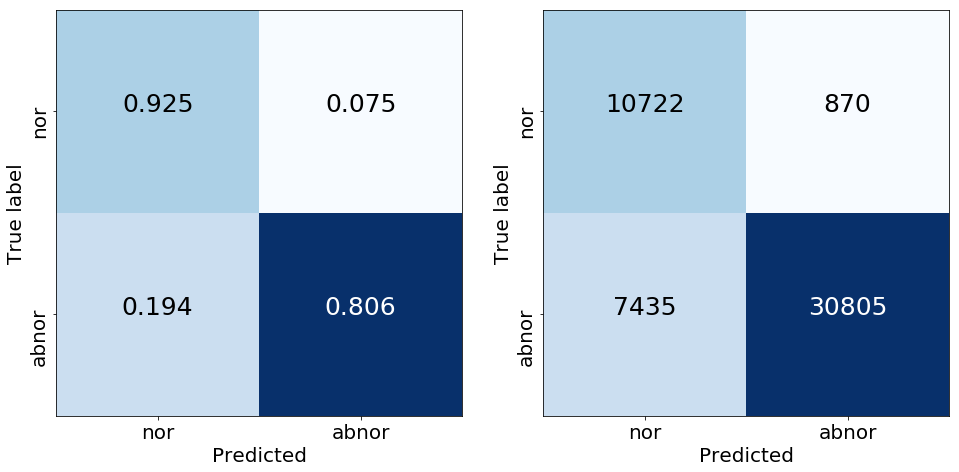

In [24]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [25]:
nd_outputs = np.vstack([neg_nd_output, ero_nd_output, ulcer_nd_output, str_nd_output])
labels = np.vstack([neg_label, ero_label, ulcer_label, str_label])

nd_CM = cls.con_mat(labels, nd_outputs)

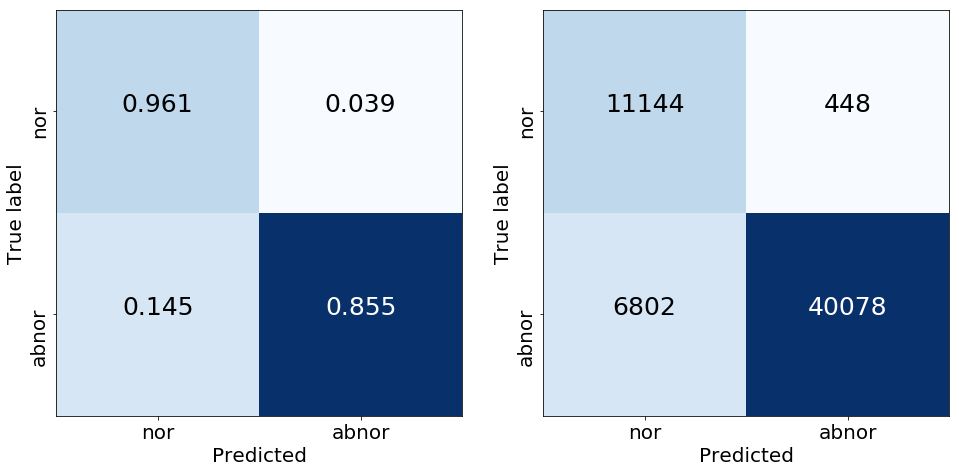

In [26]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [27]:
e_outputs = np.vstack([neg_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_CM = cls.con_mat(labels, e_outputs)

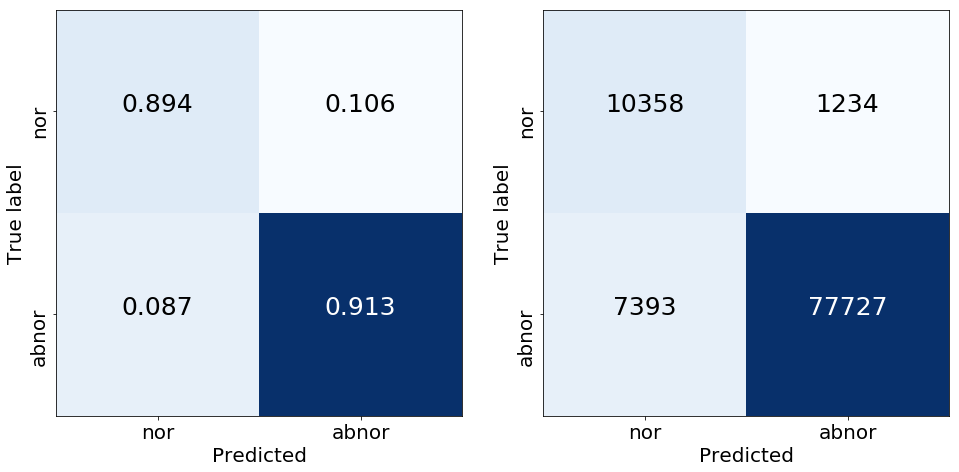

In [28]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(e_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(e_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [29]:
b_outputs = np.vstack([neg_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

b_CM = cls.con_mat(labels, b_outputs)

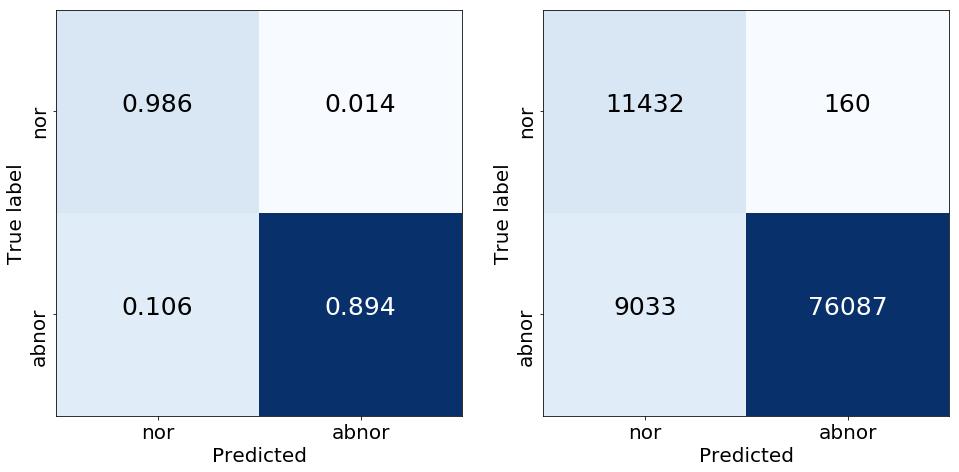

In [30]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(b_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(b_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

## ROC curve

In [31]:
from scipy.stats import sem, t
from scipy import mean

def conf_interval(data, conf_level = 0.95, mode = 'value', metric = 'Accr'):
    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + conf_level) / 2, n - 1)

    start = m - h
    end = m + h
    
    if mode == 'value':
        return m, start, end
    elif mode == 'print':
        return print("{} --- {:.2f} ({:.2f} ~ {:.2f})".format(metric, m, start, end))

In [32]:
from sklearn.model_selection import KFold

def k_fold_idx(n_fold, dataset):
    kf = KFold(n_splits = n_fold, shuffle = True)
    train_idxs = []
    test_idxs = []
    for train_idx, test_idx in kf.split(dataset):
        train_idxs.append(train_idx)
        test_idxs.append(test_idx)
    return train_idxs, test_idxs

In [33]:
n_g = 10

_, neg_idxs = k_fold_idx(n_fold = n_g, dataset = neg_label)
_, redspot_idxs = k_fold_idx(n_fold = n_g, dataset = redspot_label)
_, angio_idxs = k_fold_idx(n_fold = n_g, dataset = angio_label)
_, active_idxs = k_fold_idx(n_fold = n_g, dataset = active_label)
_, ero_idxs = k_fold_idx(n_fold = n_g, dataset = ero_label)
_, ulcer_idxs = k_fold_idx(n_fold = n_g, dataset = ulcer_label)
_, str_idxs = k_fold_idx(n_fold = n_g, dataset = str_label)

In [34]:
from sklearn.metrics import roc_curve, auc

e_aucs, b_aucs = [], []

for n_idx, r_idx, an_idx, ac_idx, e_idx, u_idx, s_idx in zip(neg_idxs, redspot_idxs, angio_idxs, active_idxs,
                                                               ero_idxs, ulcer_idxs, str_idxs):
    
    b_outputs = np.vstack([neg_b_output[n_idx], redspot_b_output[r_idx], angio_b_output[an_idx], active_b_output[ac_idx], 
                           ero_b_output[e_idx], ulcer_b_output[u_idx], str_b_output[s_idx]])
    e_outputs = np.vstack([neg_e_output[n_idx], redspot_e_output[r_idx], angio_e_output[an_idx], active_e_output[ac_idx], 
                           ero_e_output[e_idx], ulcer_e_output[u_idx], str_e_output[s_idx]])
    labels = np.vstack([neg_label[n_idx], redspot_label[r_idx], angio_label[an_idx], active_label[ac_idx], 
                        ero_label[e_idx], ulcer_label[u_idx], str_label[s_idx]])
    e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
    b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])
    e_aucs.append(auc(e_fpr, e_tpr))
    b_aucs.append(auc(b_fpr, b_tpr))

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


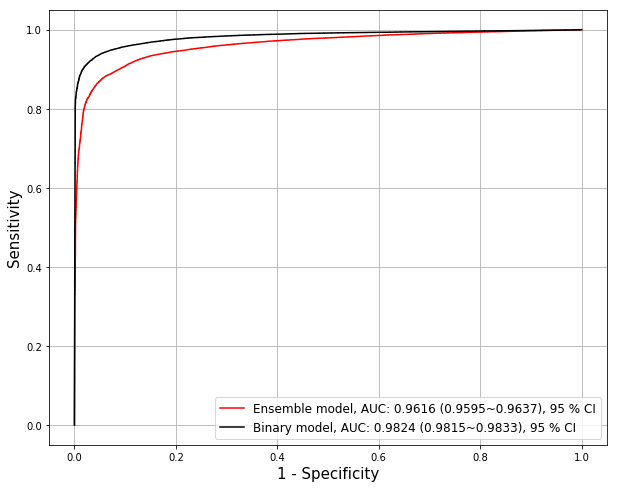

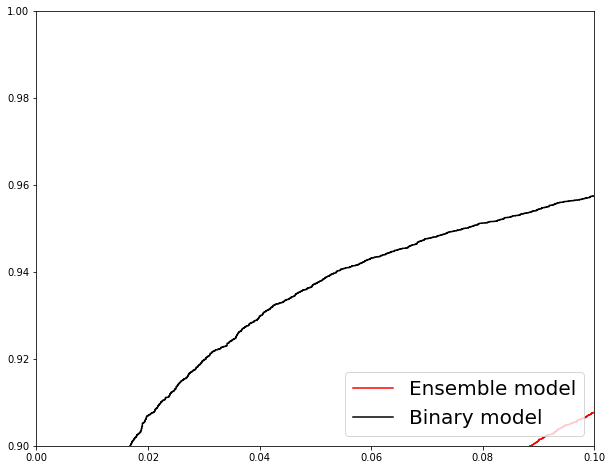

In [35]:
e_auc_m, e_auc_l, e_auc_u = conf_interval(e_aucs, mode = 'value')
b_auc_m, b_auc_l, b_auc_u = conf_interval(b_aucs, mode = 'value')

b_outputs = np.vstack([neg_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
e_outputs = np.vstack([neg_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(e_auc_m, e_auc_l, e_auc_u))
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(b_auc_m, b_auc_l, b_auc_u))
plt.xlabel('1 - Specificity', fontsize = 15)
plt.ylabel('Sensitivity', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid('on')
fig.show()

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model")
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model")
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])
plt.legend(fontsize = 20, loc = 4)
fig.show()

## Statistics

![image](http://mblogthumb3.phinf.naver.net/20121114_106/istech7_1352875002440GYyqh_PNG/%B5%CE%C1%FD%B4%DC%C2%F7%C0%CC_%B0%CB%C1%A4%B9%E6%B9%FD%C8%E5%B8%A7%B5%B5.png?type=w2)

![image](https://t1.daumcdn.net/cfile/tistory/2743524658F2520C2A)

https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F1378B94E4F9C187F23

In [36]:
e_CM, b_CM = [], []

for n_idx, r_idx, an_idx, ac_idx, e_idx, u_idx, s_idx in zip(neg_idxs, redspot_idxs, angio_idxs, active_idxs,
                                                               ero_idxs, ulcer_idxs, str_idxs):
    
    b_outputs = np.vstack([neg_b_output[n_idx], redspot_b_output[r_idx], angio_b_output[an_idx], active_b_output[ac_idx], 
                           ero_b_output[e_idx], ulcer_b_output[u_idx], str_b_output[s_idx]])
    e_outputs = np.vstack([neg_e_output[n_idx], redspot_e_output[r_idx], angio_e_output[an_idx], active_e_output[ac_idx], 
                           ero_e_output[e_idx], ulcer_e_output[u_idx], str_e_output[s_idx]])
    labels = np.vstack([neg_label[n_idx], redspot_label[r_idx], angio_label[an_idx], active_label[ac_idx], 
                        ero_label[e_idx], ulcer_label[u_idx], str_label[s_idx]])
    print(labels.shape)
    e_CM.append(cls.con_mat(labels, e_outputs)), b_CM.append(cls.con_mat(labels, b_outputs))

(9672, 2)
(9672, 2)
(9671, 2)
(9671, 2)
(9671, 2)
(9671, 2)
(9671, 2)
(9671, 2)
(9671, 2)
(9671, 2)


In [37]:
b_metrices = []
e_metrices = []

for e_cm, b_cm in zip(e_CM, b_CM):
    b_metrices.append(cls.cm2metric(b_cm))
    e_metrices.append(cls.cm2metric(e_cm))
    
b_metrices = np.asarray(b_metrices)
e_metrices = np.asarray(e_metrices)

In [38]:
b_metrices

array([[0.90612076, 0.89473684, 0.98965517, 0.56164384, 0.99842685],
       [0.90622415, 0.89461936, 0.99137931, 0.56179775, 0.99868852],
       [0.90373281, 0.89332707, 0.98015531, 0.55577299, 0.9969844 ],
       [0.9031124 , 0.89215226, 0.98360656, 0.55393586, 0.99750427],
       [0.90352601, 0.89203477, 0.98792062, 0.55474806, 0.99815959],
       [0.90569745, 0.89426692, 0.98964625, 0.56033219, 0.99842602],
       [0.90921311, 0.89884868, 0.98533218, 0.57014478, 0.99778299],
       [0.90497363, 0.8943844 , 0.98274374, 0.55888126, 0.9973798 ],
       [0.9033192 , 0.89262218, 0.98188093, 0.5545809 , 0.99724373],
       [0.90352601, 0.89179981, 0.98964625, 0.55464217, 0.99842168]])

In [39]:
e_metrices

array([[0.9103598 , 0.9118891 , 0.89913793, 0.58170664, 0.9851504 ],
       [0.90756824, 0.90566259, 0.92155172, 0.57104701, 0.98833333],
       [0.90941992, 0.91365132, 0.8783434 , 0.58071877, 0.98219247],
       [0.90631786, 0.91024436, 0.87748059, 0.57102751, 0.98200253],
       [0.9085927 , 0.91329887, 0.87402934, 0.57852656, 0.98156566],
       [0.91324579, 0.91635338, 0.89042278, 0.59174312, 0.98397881],
       [0.91665805, 0.9175282 , 0.91026747, 0.60045532, 0.98685873],
       [0.9139696 , 0.91647086, 0.89559965, 0.59348199, 0.98472608],
       [0.91128115, 0.91353383, 0.89473684, 0.58488438, 0.98455305],
       [0.91055734, 0.91282895, 0.89387403, 0.58267717, 0.98441657]])

In [40]:
print("95 % CI\n")

print('Binary model')
conf_interval(100*b_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*b_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*b_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*b_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*b_metrices[:, 4], mode = 'print', metric = 'PPV')
print('')
print('Ensemble model')
conf_interval(100*e_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*e_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*e_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*e_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*e_metrices[:, 4], mode = 'print', metric = 'PPV')

95 % CI

Binary model
Accr --- 90.49 (90.36 ~ 90.63)
Sen --- 89.39 (89.24 ~ 89.54)
Spec --- 98.62 (98.34 ~ 98.90)
NPV --- 55.86 (55.50 ~ 56.23)
PPV --- 99.79 (99.75 ~ 99.83)

Ensemble model
Accr --- 91.08 (90.86 ~ 91.30)
Sen --- 91.31 (91.07 ~ 91.56)
Spec --- 89.35 (88.29 ~ 90.42)
NPV --- 58.36 (57.69 ~ 59.04)
PPV --- 98.44 (98.29 ~ 98.59)


### Equal-Variance Test

In [41]:
from scipy.stats import bartlett

accr_stats = bartlett(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = bartlett(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = bartlett(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = bartlett(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = bartlett(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("bartlett test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("bartlett test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("bartlett test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("bartlett test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("bartlett test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

bartlett test for accuracy: 1.944, pvalue=0.163185436086
bartlett test for sensitivity: 2.090, pvalue=0.148264678357
bartlett test for specificity: 11.931, pvalue=0.000552052483
bartlett test for negative predictive values: 3.095, pvalue=0.078551110262
bartlett test for positive predictive values: 11.156, pvalue=0.000837597530


In [42]:
from scipy.stats import levene

accr_stats = levene(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = levene(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = levene(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = levene(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = levene(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("levene test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("levene test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("levene test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("levene test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("levene test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

levene test for accuracy: 1.321, pvalue=0.265448496379
levene test for sensitivity: 0.988, pvalue=0.333347388720
levene test for specificity: 5.509, pvalue=0.030552453106
levene test for negative predictive values: 2.033, pvalue=0.171020304417
levene test for positive predictive values: 5.308, pvalue=0.033369365732


### Normality Test

In [43]:
from scipy.stats import ks_2samp

accr_stats = ks_2samp(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ks_2samp(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ks_2samp(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ks_2samp(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ks_2samp(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("Kolmogorov-Smirnov test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("Kolmogorov-Smirnov test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("Kolmogorov-Smirnov test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("Kolmogorov-Smirnov test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("Kolmogorov-Smirnov test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

Kolmogorov-Smirnov test for accuracy: 0.900, pvalue=0.000216501764
Kolmogorov-Smirnov test for sensitivity: 1.000, pvalue=0.000010825088
Kolmogorov-Smirnov test for specificity: 1.000, pvalue=0.000010825088
Kolmogorov-Smirnov test for negative predictive values: 1.000, pvalue=0.000010825088
Kolmogorov-Smirnov test for positive predictive values: 1.000, pvalue=0.000010825088


### Wilcoxon signed-ranks test (not normal and paired group)

In [44]:
from scipy.stats import wilcoxon

accr_stats = wilcoxon(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = wilcoxon(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = wilcoxon(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = wilcoxon(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = wilcoxon(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("wilcoxon signed-ranks test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("wilcoxon signed-ranks test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("wilcoxon signed-ranks test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("wilcoxon signed-ranks test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("wilcoxon signed-ranks test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

wilcoxon signed-ranks test for accuracy: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for sensitivity: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for specificity: 0.000, pvalue=0.005033508201
wilcoxon signed-ranks test for negative predictive values: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for positive predictive values: 0.000, pvalue=0.005062032126


### Paired two-sample t-Test (normal and paired group)

In [45]:
from scipy.stats import ttest_rel

accr_stats = ttest_rel(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ttest_rel(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ttest_rel(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ttest_rel(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ttest_rel(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("t-statistics for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("t-statistics for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("t-statistics for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("t-statistics for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("t-statistics for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

t-statistics for accuracy: -7.721, pvalue=0.000029366200
t-statistics for sensitivity: -18.220, pvalue=0.000000020628
t-statistics for specificity: 21.541, pvalue=0.000000004713
t-statistics for negative predictive values: -10.242, pvalue=0.000002931016
t-statistics for positive predictive values: 21.894, pvalue=0.000000004082


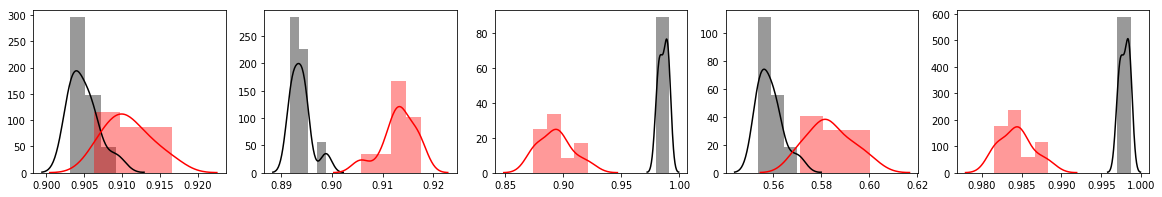

In [46]:
## Distribution by metric

import seaborn as sns

fig, axes = plt.subplots(ncols = 5)
fig.set_size_inches(20, 3)

sns.set_style({'axes.grid' : True})

sns.distplot(b_metrices[:, 0], color='k', ax = axes[0])
sns.distplot(e_metrices[:, 0], color='r', ax = axes[0])
sns.distplot(b_metrices[:, 1], color='k', ax = axes[1])
sns.distplot(e_metrices[:, 1], color='r', ax = axes[1])
sns.distplot(b_metrices[:, 2], color='k', ax = axes[2])
sns.distplot(e_metrices[:, 2], color='r', ax = axes[2])
sns.distplot(b_metrices[:, 3], color='k', ax = axes[3])
sns.distplot(e_metrices[:, 3], color='r', ax = axes[3])
sns.distplot(b_metrices[:, 4], color='k', ax = axes[4])
sns.distplot(e_metrices[:, 4], color='r', ax = axes[4])

fig.show()